# A first look at ApRES data

Earlier in this chapter we looked at the theory behind the autonomous phase-sensitive radio-echo sounder (ApRES), developed by the British Antarctic Survey (BAS). We have seen how it is the frequency content of the signal recorded by ApRES which tells us the range to sub-surface reflectors and how to use a fourier transform to estimate this frequency content and estimate the range to reflectors. 

Below we will load and examine ApRES data collected on Thwaites Glacier as part of the International Thwaites Glacier Collaboration (ITGC). 


## Load packages
As well as numpy and matplotlib, we will use a package called [xapres](https://github.com/ldeo-glaciology/xapres) which was developed to load and process ApRES data in python. xapres is built around xarray, a package for working with multi-dimensional arrays. 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import sys
#sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres/")
import xapres as xa


## The data
The data we will use was collected on Thwaites Glacier, West Antarctica, by Elizabeth Case as part of the GHOST overland traverse in the 2022-2023 field season. Follow up data was collected Alex Brisbourne and Sierra Melton in 2023-2024. Part of these ApRES surveys was a line of measurements taken along a profile approximately aligned with flow down the middle of the glacier. 

As described in previous pages, ApRES data is collected in 'chirps', each one second in length. Generally, many chirps are recorded repeatedly at each location and together these are known as a burst. 

At each of ~250 waypoints, Elizabeth collected a burst consisting of 100 chirps. 

ApRES data is stored in a binary format with the file extension .dat. The xapres package has tools to load this data format.

## Load the data
The cell below creates a `from_dats` object, which will be used to load the data.

In [6]:
fd = xa.load.from_dats(max_range=2500)

The Thwaites Glacier ApRES data is stored in an open google bucket. We can list and count the .dat files in the bucket as follows:

In [7]:
root_directory = 'gs://ldeo-glaciology/apres/thwaites/'
filenames = fd.list_files(directory = root_directory, remote_load=True)
len(filenames)

2301

There are thousands of .dat files from different seasons and different locations. We will chose a .dat file at random to load (note that most of these data are arranged so that one .dat file is in each directory, but this is not always the case, so we specify `file_numbers_to_process=[0]` to ensure we only load one file). 

In [8]:
directory = os.path.dirname(filenames[20])
ds = fd.load_all(directory = directory, remote_load=True, file_numbers_to_process=[0])
ds

<xarray.Dataset>
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2022-12-31T09:18:13
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U86 'ldeo-glaciology/apres/thwaites/2022-2023/Po...
    burst_number     (time) int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 26.0
    orientation      (time) <U7 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0
    longitude        (time) float64 0.0
    battery_voltage  (time) float64 0.2296
    temperature_1    (time) float64 505.5
    temperature_2    (time) float64 505.0

This produced an xarray Dataset contained many variables. The only one we are interested in right now is `ds.chirp`, which is the voltage recorded by ApRES during each one-second chirp. This is the so-called deramped signal. It is the result of combining the tranmsitted chirp with the received signal. See the two previous pages for more details. 

In [9]:
chirp = ds.chirp.squeeze()    # .squeeze() removes the singleton dimensions
chirp

<xarray.DataArray 'chirp' (chirp_time: 40001, chirp_num: 100)>
array([[ 6.86645508e-04,  4.70352173e-02, -3.73840332e-03, ...,
         9.42230225e-03,  2.36892700e-02,  5.51605225e-02],
       [ 2.48718262e-02,  7.32421875e-02,  2.11334229e-02, ...,
         3.80325317e-02,  4.21524048e-02,  7.84301758e-02],
       [ 1.23443604e-01,  2.06375122e-01,  1.13945007e-01, ...,
         1.49841309e-01,  1.29928589e-01,  1.91040039e-01],
       ...,
       [ 5.45120239e-02,  4.97055054e-02,  4.74548340e-02, ...,
         4.46319580e-02,  5.30624390e-02,  5.40542603e-02],
       [ 8.31985474e-02,  8.68606567e-02,  6.67953491e-02, ...,
         7.78198242e-02,  8.02993774e-02,  7.90023804e-02],
       [ 9.29603577e-01,  9.34638977e-01,  9.12284851e-01, ...,
         9.14497375e-01,  9.12971497e-01,  9.11254883e-01]])
Coordinates:
    time          datetime64[ns] 2022-12-31T09:18:13
  * chirp_time    (chirp_time) float64 0.0 2.5e-05 5e-05 7.5e-05 ... 1.0 1.0 1.0
  * chirp_num     (chirp_num) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
    filename      <U86 'ldeo-glaciology/apres/thwaites/2022-2023/Point/G1-25-...
    burst_number  int64 0
    AFGain        int64 -4
    attenuator    float64 26.0
    orientation   <U7 'unknown'
Attributes:
    long_name:    de-ramped chirp
    units:        volts
    description:  voltage from the analog-to-digital converter after the rece...

This is one burst of data, recorded on New Year's Eve 2022. It is a real-valued array with two dimensions: chirp_time and chirp_num. Chirp_time is the time during each chirp. It ranges from 0 to 1 second. The sample frequency is 40,001 Hz, so the chirp_num dimension is 40,001 long. Chirp_num is the chirp number. There were 100 chirps in this burst, so the length of the chirp_num dimension is 100. In other words, `chirp` contains 100 chirps, each 40,001 elements long. 

## Plot the chirps
Plotting one of these chirps, we get something superficially reminiscent of the synthetic chirp we generated earlier in this chapter using 10 randomly placed reflectors.

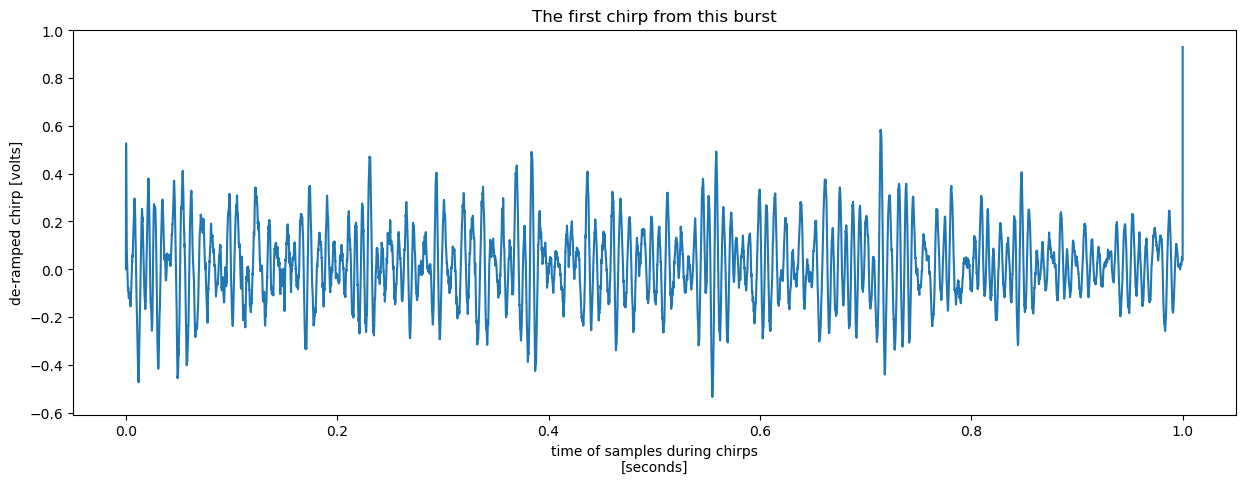

In [10]:
chirp.isel(chirp_num=0).plot(x = 'chirp_time', figsize = (15, 5))
plt.title("The first chirp from this burst");

We can also plot all 100 chirps on the same plot to see how they compare.
There are at least two way to do this. One is to plot each chirp as a line on the same plot:

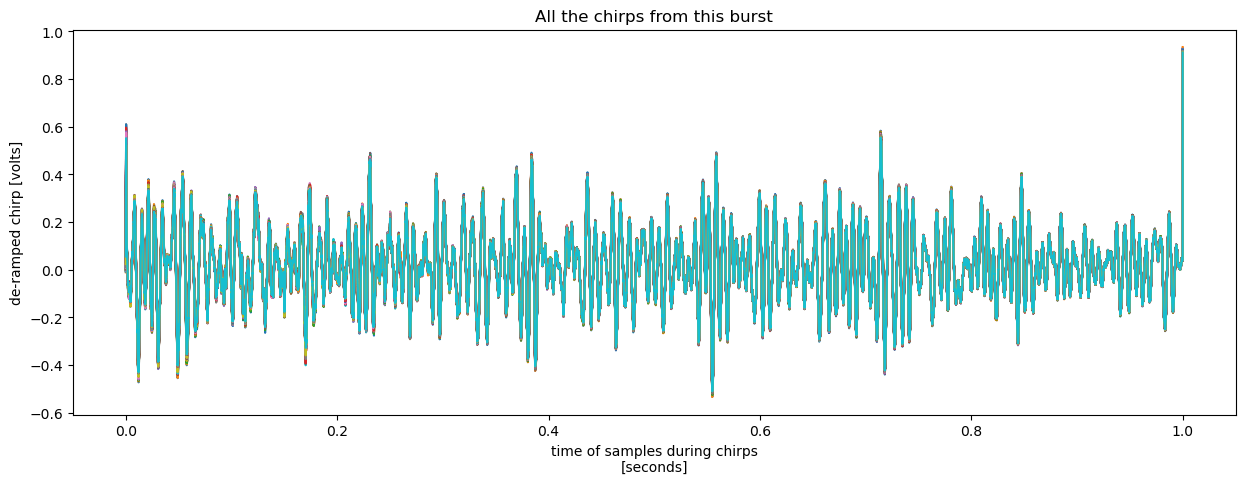

In [11]:
chirp.plot(x = 'chirp_time', hue = 'chirp_num',  add_legend = False, figsize = (15, 5))
plt.title("All the chirps from this burst");

another is to plot a 2D plot with chirp number on one axis and chirp time on the other:

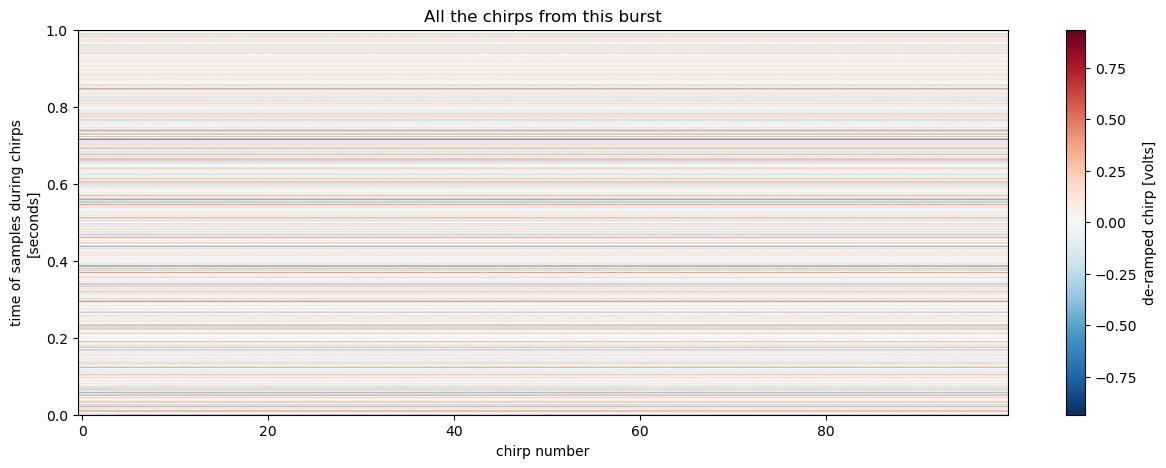

In [12]:
chirp.plot(figsize = (15, 5))
plt.title("All the chirps from this burst");

It is evident just from looking at either of the two plots above that (1) there is a high degree of agreement between the chirps, and (2) some frequencies are particularly prominent. 

### Agreement between chirps
Let's zoom in on the line plot above to examine the agreement between chirps.

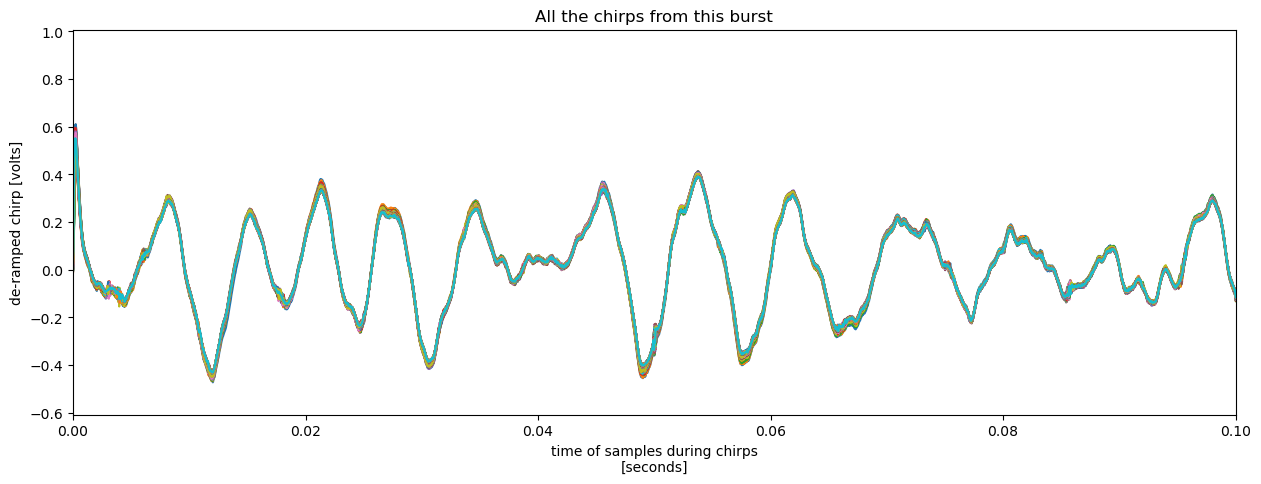

In [13]:
chirp.plot(x = 'chirp_time', hue = 'chirp_num',  add_legend = False, figsize = (15, 5), xlim = (0, 0.1))
plt.title('All the chirps from this burst');

At this scale its clear that the chirps are similar, particularly at long periods, but not identical. 

More useful still is to compute the deviation from the mean chirp.

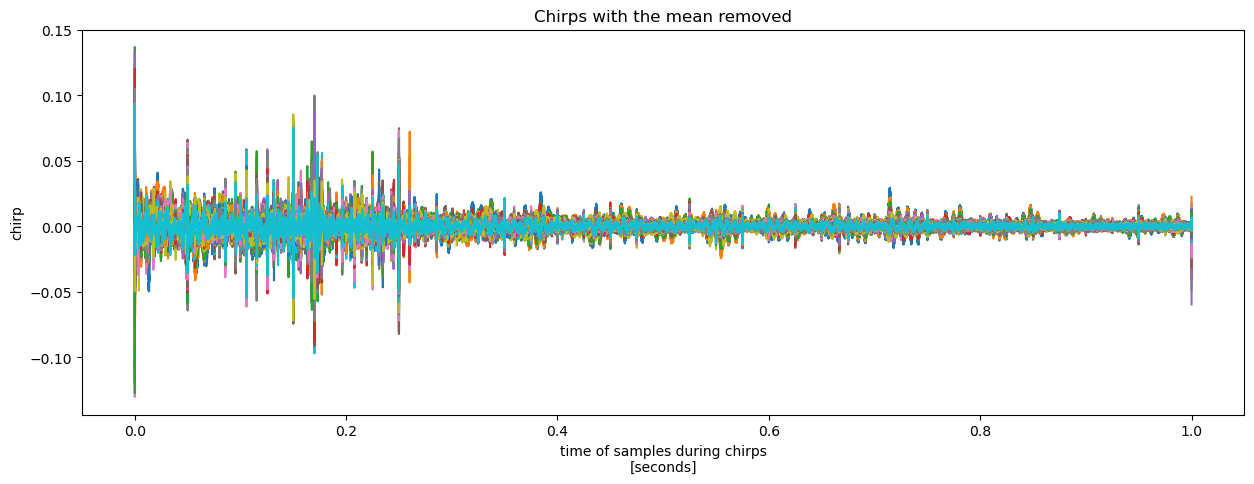

In [14]:
mean_chirp = chirp.mean(dim='chirp_num')
(chirp - mean_chirp).plot(x = 'chirp_time', hue = 'chirp_num', add_legend = False, figsize = (15, 5))
plt.title('Chirps with the mean removed');

This highlights how the deviations are an order of magnitude smaller than the signal and relatively high frequency. This is good news, as these chirps were all recorded at the same location within a 100-second interval, so we would hope for significant agreement.

### A prominent frequency
To examine the second point above, as a very approximate estimate, you can manually count the peaks (or the horizontal lines in the lower plot). Doing this I counted around 25 peaks in the first 0.2 seconds of the chirp. This suggests a frequency of around 125 Hz.

From earlier in this chapter, the range $R$ is related to the frequency $f_d$ by

$$ 
R = \frac{c}{2\sqrt\epsilon} \frac{f_d}{K},
$$

where $c$ is the speed of light, $\epsilon$ is the permittivity of the ice, and $K$ is the rate of change of frequency during the chirps. This can be understood by considering that the delay in the received signal returning to the radar is the two-way travel time $\tau = 2R\frac{\sqrt\epsilon}{c}$ and because $K$ is constant, this delay is linearly proportional to the difference in the transmitted and received frequencies: $f_d = K\tau.$ eliminating $\tau$ between these two expressions gives the equation above.

Using this equation for $R$, a frequency of 125Hz corresponds to a range of around 53 m:

In [15]:
T = 1               # chirp duration [s]
f_1 = 200e6         # starting frequency [Hz]
f_2 = 400e6         # ending frequency [Hz]
B = f_2 - f_1       # bandwidth [Hz]
K = B/T             # rate of chnge of frequency [Hz/s]
c = 299792458       # speed of lightin a vacuum [m/s]
ep = 3.1            # permittivity of ice

def range(frequencies):
    return c * frequencies / (2*np.sqrt(ep)*K)

range(125)

53.2095857309738

So we will know to look out for a reflector at around 53 m depth in the amplitude plot we will make next. 

## Plot the power
As discussed, the frequency content of the chirps contains infomation on the locations of sub-surface reflectors. We can estimate this frequency content using a fourier transform, and then plot the result as a function of range to produce something similar to the time series of return strength you would record with a conventional radar system.

Initially we will use the same fourier transform code as we used earlier in the chapter when playing with synthetic data. 

First let's extract just one chirp on which to perform the fourier transform.

In [16]:
s_one_chirp = chirp.isel(chirp_num=0).values.squeeze()  # again, .squeeze() removes unnecessary singleton dimensions)

Then we define a function that takes a chirp, performs an fft on it, and returns the result and the frequencies of the bins. 

```{note}
It is very nearly identical to the code used in {ref}`page:apres-theory`) execpt for the addition of `, axis=0` in the call to `np.fft.fft`. This has no effect except to allows us to use the same function to process every chirp in one go later on. 
```

In [17]:
dt = chirp.chirp_time.values[1] - chirp.chirp_time.values[0]
sampling_frequency = 1/dt   # [Hz]
def fft(s):
    no_of_samples = len(s)
    S = np.fft.fft(s, axis=0)/no_of_samples         
    indexes      = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    return S, frequencies

Next we perform the fft and plot the results. The fft returns a complex number for each frequency bin. We can start by plotting the magnitude of these complex numbers:

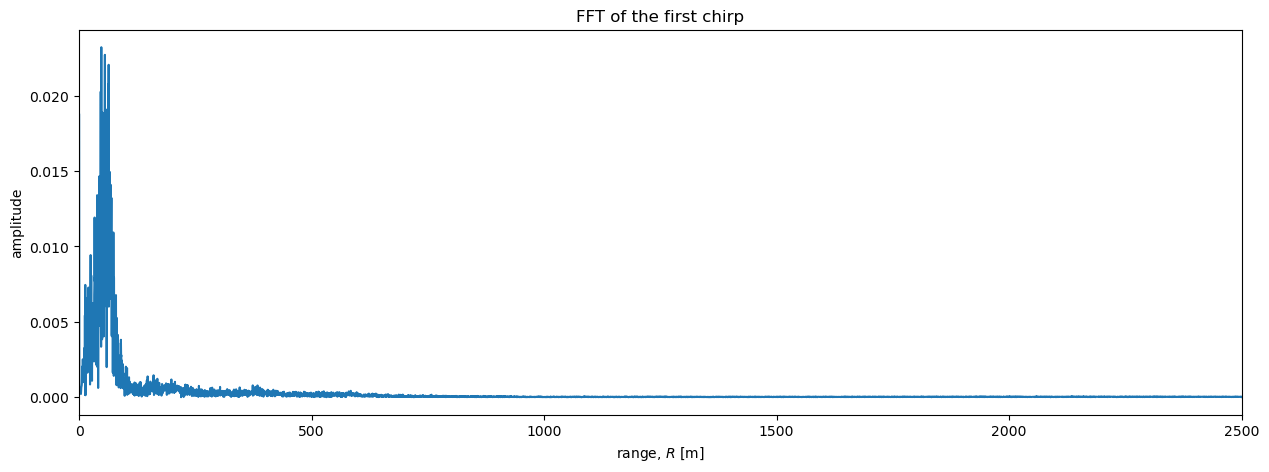

In [18]:
S_one_chirp, frequencies = fft(s_one_chirp)
r = range(frequencies)

plt.figure(figsize = (15, 5))
plt.plot(r, abs(S_one_chirp)); 
plt.xlabel('range, $R$ [m]')
plt.ylabel('amplitude')
plt.xlim([0, 2500])
plt.title('FFT of the first chirp');

It is difficult to see details in the region $R>$ 500 me plot above. A logarithmic scale will be useful here. In particular, radar data is often plotted on a decibel scale as follows:

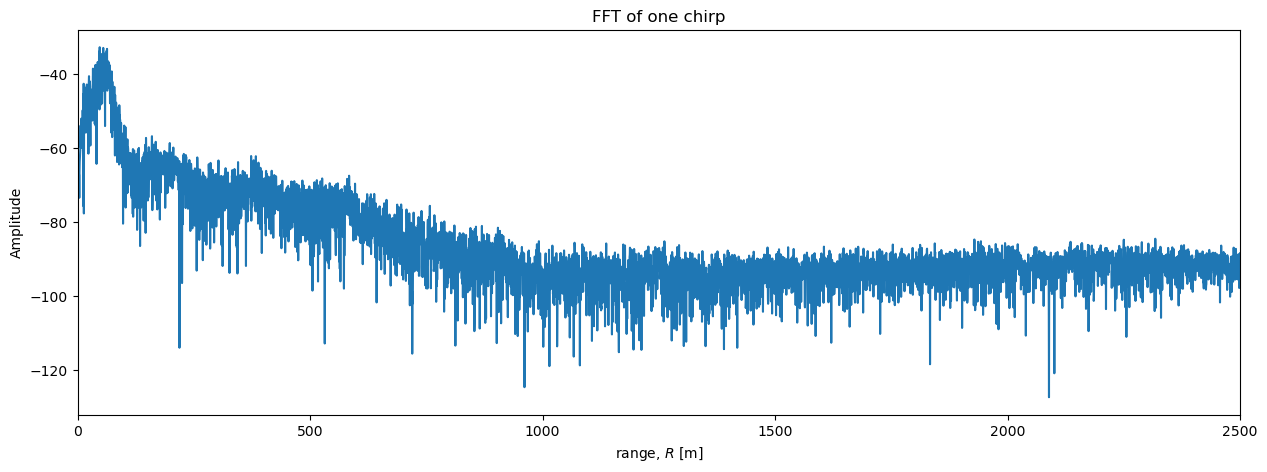

In [19]:
def dB(S):
    return 20*np.log10(np.abs(S))

plt.figure(figsize = (15, 5))
plt.plot(r, dB(S_one_chirp))
plt.xlabel('range, $R$ [m]')
plt.ylabel('Amplitude')
plt.xlim([0, 2500]);
plt.title('FFT of one chirp');

Now we can see more detail. The power initially increases with range to a peak at around 50 m, then decreases steadily until around 1000 m, after which the power stays approximately uniform with range. A peak in power around 50 m is consistent with our simple estimate based on counting peaks in the chirp above. Based on past experience with similar data, we can intepret all the little spikes in power in the region between the surface ($R$ = 0) and $R$ = 1000 m as englacial reflectors. While where $R>1000$ m, any reflectors are too lower power to be detected above the noise and the power we see in that region is background noise from the environment and possibly the radar system. 

## Stacking
To reduce the level of noise we can 'stack' the data. This involves averaging returns from multiple chirps so that the random noise tends to cancel out while the signal (reflections from sub-surface reflectors) remains. 

### Order of operations
You can either average all the chirps and compute the fft of the result, or you can compute the fft of each chirp and average the resulting power profiles. 
We will start with the simpler, former option. 

First, we average the chirps acorss the `chirp_num` dimension:

In [20]:
s_stacked = chirp.mean(dim='chirp_num').values.squeeze()

Then we perform the fft and plot the results as before:

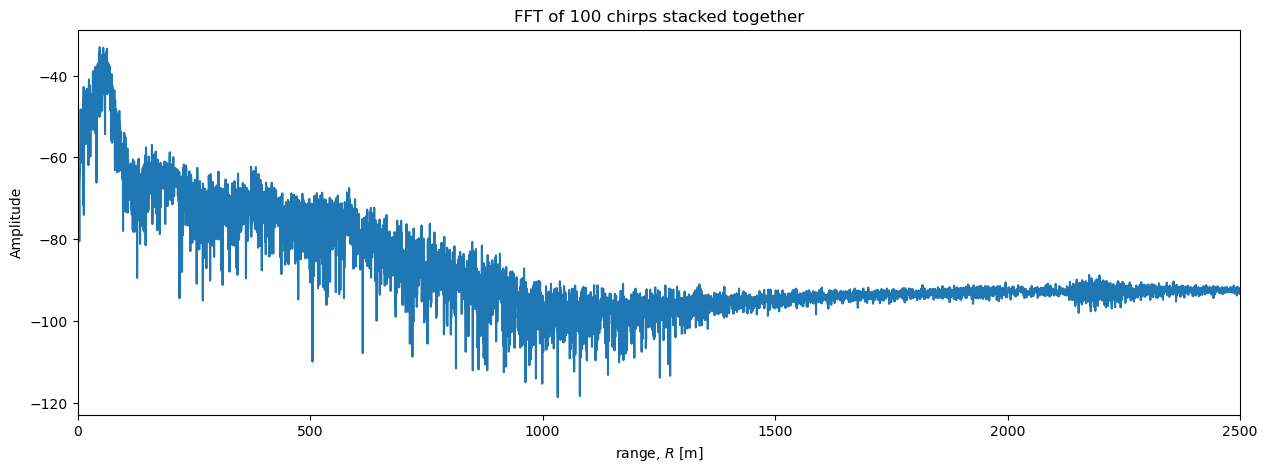

In [26]:
S_stacked, frequencies = fft(s_stacked)
r = range(frequencies)

plt.figure(figsize = (15, 5))
plt.plot(r, dB(S_stacked)); 
plt.xlabel('range, $R$ [m]')
plt.ylabel('Amplitude')
plt.xlim([0, 2500])
plt.title('FFT of 100 chirps stacked together');

For completeness, we also perform the stacking operations in the other order.

We feed the whole 2D array of chirps into our fft function

In [22]:
s_all = chirp.values
S_all, frequencies = fft(s_all)

Then plot the result and verify that the two methods give the same result to within numeical precision:

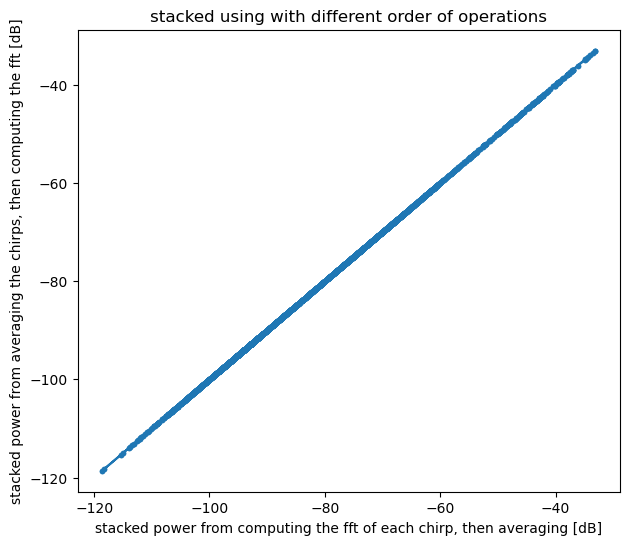

In [23]:
plt.figure(figsize = (7, 6))
plt.plot(dB(S_all.mean(axis=1)), dB(S_stacked), marker = '.') 
plt.xlabel('stacked power from computing the fft of each chirp, then averaging [dB]')
plt.ylabel('stacked power from averaging the chirps, then computing the fft [dB]')
plt.title('stacked using with different order of operations');

assert np.allclose(S_all.mean(axis=1), S_stacked)

## Stacking reveals more details
Comparing the single-chirp plot to the stacked plot above shows how stacking lowers the level of noise and reveals more detail at depth.

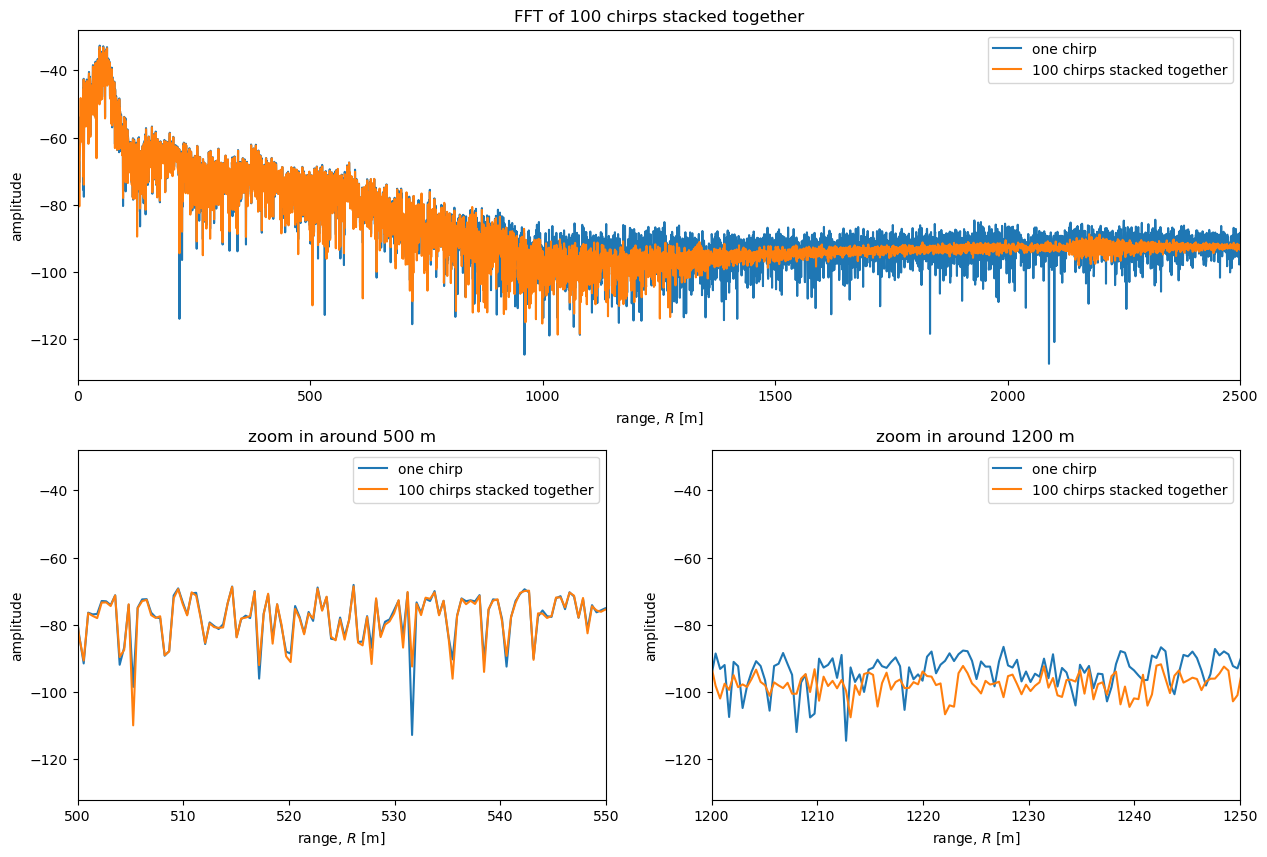

In [28]:
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])  # Top subplot spanning both columns
ax2 = fig.add_subplot(gs[1, 0])  # Bottom left subplot
ax3 = fig.add_subplot(gs[1, 1])  # Bottom right subplot

for ax in [ax1, ax2, ax3]:
    ax.plot(r, dB(S_one_chirp), label='one chirp'); 
    ax.plot(r, dB(S_stacked), label = '100 chirps stacked together'); 
    ax.set_xlabel('range, $R$ [m]')
    ax.set_ylabel('amplitude')
    ax.legend()

ax1.set_title('FFT of 100 chirps stacked together');
ax2.set_title('zoom in around 500 m');
ax3.set_title('zoom in around 1200 m');

ax1.set_xlim([0, 2500])
ax2.set_xlim([500, 550])
ax3.set_xlim([1200, 1250]);

The bottom left plot above shows a zoom in of the unstacked and stacked power profiles around $R=$ 500m. At this depth the reflectors are much higher power than the noise and there is little difference between the curves. The bottom right plot above is a zoom in around $R=$ 1200 m. In this region stacking significantly affects the power. This potentially allows reflectors to be detected that would not have been detected in a power profile from a single chirp.

This is consistent with our observation earlier that the chirps agree well at low frequencies but appeared to disagree at higher frequencies; low frequencies correspond to shallow depths (low $R$), while higher frequencies correspond to deeper depths (higher $R$). 

One important reflector that the stacking reveals is the reflection from the bed. It is visible at around $R=$ 2200m; a local peak in the power is visible in the stacked data, but not in the unstacked data. This reflection is weak compared to reflectors higher up because the radio signal is attenuated during its 4400 m journey through the ice, but incredibly it can be traced between stacked ApRES measurements taken at adjacent waypoints along the TG flowline traverse. See Elizabeth Case's [thesis](https://www.proquest.com/openview/0d465d08318c086bdc146f944409b360/1?pq-origsite=gscholar&cbl=18750&diss=y) for more details.

## Preprocessing
So far we have simply directly computed the FFT of the chirps. 

Based on software developed by BAS, several preprocessing steps can be applied to ApRES data before the FFT is computed, including applying a blackman filter and padding the data with zeros to increase the number of frequency bins. This helps with abotaininga clreaer power return, revealing additional details in the data, and helps with subsequent processing steps aimed at measuring the displacement of reflectors. 


### Trim the data
It is useful to defining two simple rounding functions for making sure the data have an even number of samples.

In [29]:
def rdi(x):
    """round down to the nearest integer and return an integer"""
    return int(np.floor(x))
def rdei(x):
    """round down to the nearest even integer and return an integerr"""
    return int(np.floor(x/2) * 2)

Next extract and trim the data to have an even number of samples

In [30]:
t = chirp.chirp_time.values
N = rdei(len(s_one_chirp))
s_t = s_one_chirp[:N]             # t suffix stands for 'trimmed'
t_t = t[:N]                       # t suffix stands for 'trimmed'

### Filtering
We filter the data using the numpy function `np.blackman` and simply multipying the data by the output of this function. 

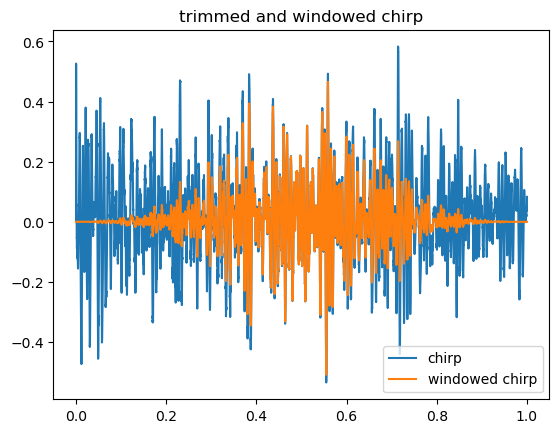

In [31]:
s_tw = s_t * np.blackman(N)       # w suffix stands for 'windowed'

plt.plot(t_t, s_t, label = 'chirp')
plt.plot(t_t, s_tw, label = 'windowed chirp')
plt.legend()
plt.title('trimmed and windowed chirp');

### Padding the data
Padding the data with zeros increases the frequency resolution of the resulting prower profile, simplifying later processing steps. 

We define a pad factor, which is the factor by which we will increase the number of samples in the data. I.e. if there are initially 40,000 samples in the chirp (after trimming), and we set `pad=2`, there will be 80,000 samples in the padded chirp.

In [32]:
pad_factor = 2

Numpy's `pad` function requires the number of zeros to add to each side of the array. Considering the total number of additional elements (`N*pad_factor - N `) and dividing this by two relates this to the pad factor as `(N*pad_factor-N)/2`.

80000

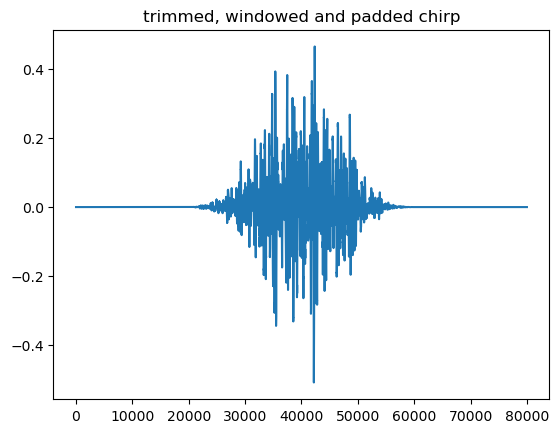

In [33]:
s_twp = np.pad(s_tw, pad_width=int((N*pad_factor-N)/2))      # p suffix stands for 'padded'

plt.plot(s_twp)
plt.title('trimmed, windowed and padded chirp')
len(s_twp)

### Roll
Another step in the preprocessing is to rearrange the data with a roll operation as follows:

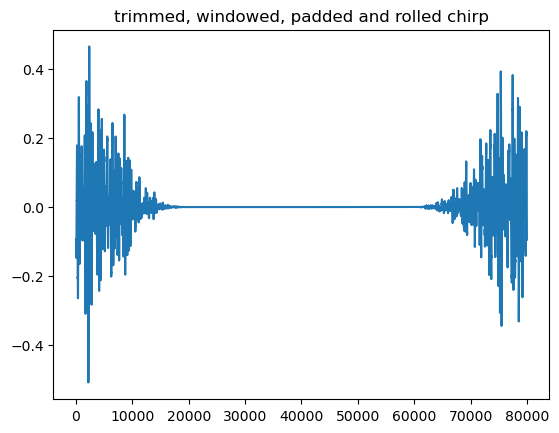

In [34]:
s_twpr = np.roll(s_twp, shift = int(N*pad_factor/2))   # r suffix stands for 'rolled'
plt.plot(s_twpr)
plt.title('trimmed, windowed, padded and rolled chirp');

### Perform the FFT on the rolled, padded chirp

In [35]:
S_twpr, frequencies = fft(s_twpr) 
S_twpr = S_twpr * np.sqrt(2*pad_factor) 
r_twpr = range(frequencies)

You can see the effect of padding on the range resolution by comparing the ragne bins obtained with and without padding

In [36]:
print(f"Range resolution without padding; {r[1] - r[0]} m.")
print(f"Range resolution with padding: {r_twpr[1] - r_twpr[0]} m.")

Range resolution without padding; 0.4256660441966854 m.
Range resolution with padding: 0.2128383429238952 m.


Finally, we plot the power profiles from the preprocessed an original chirps.

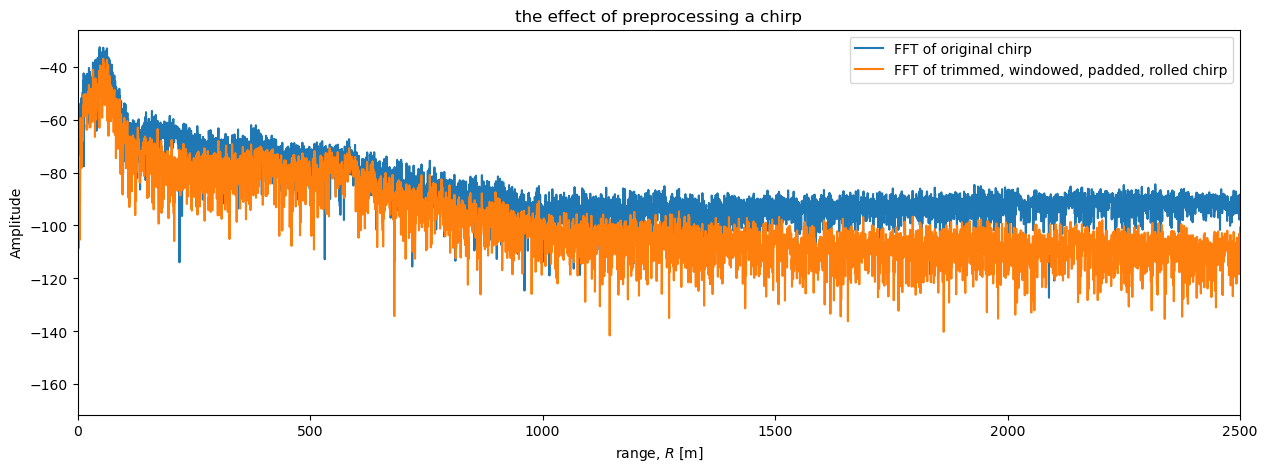

In [37]:
plt.figure(figsize = (15, 5))
plt.plot(r, dB(S_one_chirp), label = 'FFT of original chirp')
plt.plot(r_twpr, dB(S_twpr), label = 'FFT of trimmed, windowed, padded, rolled chirp')
plt.xlabel('range, $R$ [m]')
plt.ylabel('Amplitude')
plt.xlim([0, 2500])
plt.title('the effect of preprocessing a chirp')
plt.legend();

## Performing all these steps with xapres
The xapres package performs all these steps on the chirps as they are loaded and saves the result into another data variable called profile. The package also adds a method called `.dB` to the xarray to simplify plotting the power profile on a decibel scale.

To plot the the power profiles you can use xarray's plotting tools as follows:

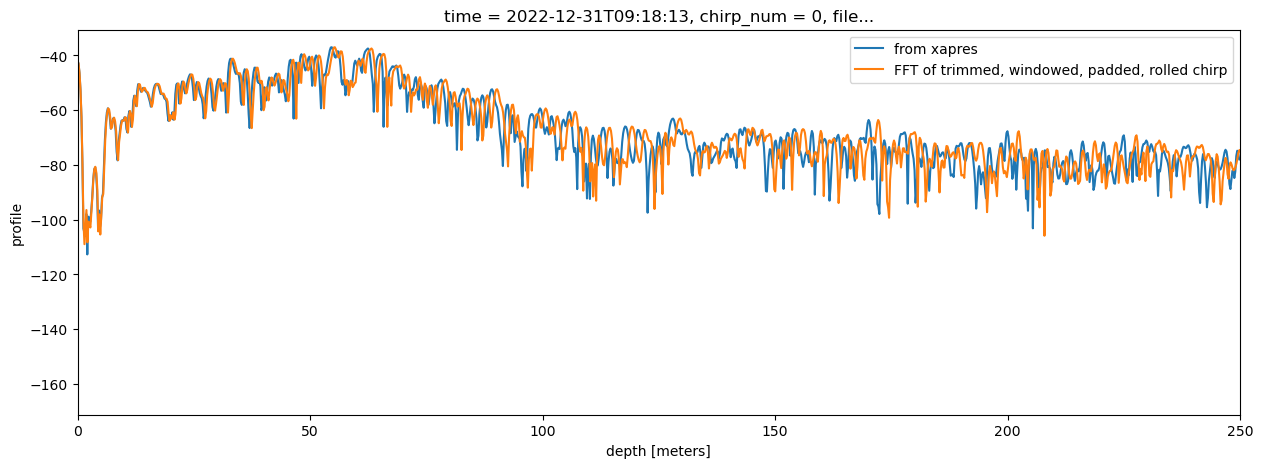

In [38]:
ds.profile.isel(chirp_num=0).dB().plot(figsize = (15, 5), label = 'from xapres')
plt.plot(r_twpr, dB(S_twpr), label = 'FFT of trimmed, windowed, padded, rolled chirp')
plt.xlim([0, 250])
plt.legend()


In [39]:
ds.profile.profile_range

<xarray.DataArray 'profile_range' (profile_range: 11889)>
array([0.000000e+00, 2.102896e-01, 4.205791e-01, ..., 2.499502e+03,
       2.499712e+03, 2.499922e+03])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 2.5e+03 2.5e+03
Attributes:
    long_name:  depth
    units:      meters

In [40]:
r_twpr


array([0.00000000e+00, 2.12838343e-01, 4.25676686e-01, ...,
       1.70264289e+04, 1.70266418e+04, 1.70268546e+04])

In [ ]:
self.Header["c0"]/(2.*(T1-T0)*pad*math.sqrt(self.Header["ER_ICE"])*self.Header["K"])

In [42]:
Nt = rdei(len(s_t))
Nfft = rdi(Nt*pad_factor)
bin2m1 = c/(2*pad_factor*np.sqrt(ep)*K)
r_padded1 = np.arange(Nfft) * bin2m1
r_padded1

array([0.00000000e+00, 2.12838343e-01, 4.25676686e-01, ...,
       1.70264289e+04, 1.70266418e+04, 1.70268546e+04])

In [41]:
ds = fd.load_all(directory = directory, remote_load=True, file_numbers_to_process=[0])
